In [1]:
# import sys
# import gymnasium as gym
# sys.modules["gym"] = gym
import gym
gym.__version__

'0.21.0'

In [2]:
import gnwrapper

In [3]:
import os
import numpy as np
import torch
print(torch.cuda.is_available())

True


In [4]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [5]:
env_id = "MountainCarContinuous-v0"
NUM_CPU = 32  # Number of processes to use

In [6]:
# Parallel environments
train_env = make_vec_env(env_id, n_envs=NUM_CPU)
train_env.observation_space

/home/vlad1slav/Diploma/rl-venv/lib/python3.10/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Box([-1.2  -0.07 -3.  ], [0.6  0.07 3.  ], (3,), float32)

In [15]:
eval_callback = EvalCallback(train_env, 
                             best_model_save_path="./logs/best_model",
                             log_path="./logs/results", 
                             eval_freq=500,
                             deterministic=True, render=False)
model = PPO("MlpPolicy", 
            train_env,
            verbose=1, 
            seed=0,
            batch_size=512,
            # ent_coef=0.00429,
            learning_rate=7.77e-05,
            n_epochs=10,
            n_steps=8*NUM_CPU,
            gae_lambda=0.9,
            gamma=0.9999,
            # clip_range=0.1,
            max_grad_norm=5,
            # vf_coef=0.19,
            use_sde=True,
            # policy_kwargs=dict(log_std_init=-3.29, ortho_init=False),
            tensorboard_log="./logs/ppo_MountainCar_tensorboard/")

model.learn(total_timesteps=1_000_000, callback=eval_callback, progress_bar=True)
model.save("./logs/ppo_MountainCar")

del model # remove to demonstrate saving and loading

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,004,992/1,000,000  [ 0:01:02 < 0:00:00 , 17,980 it/s ]
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1,004,992/1,000,000  [ 0:01:02 < 0:00:00 , 17,980 it/s ]

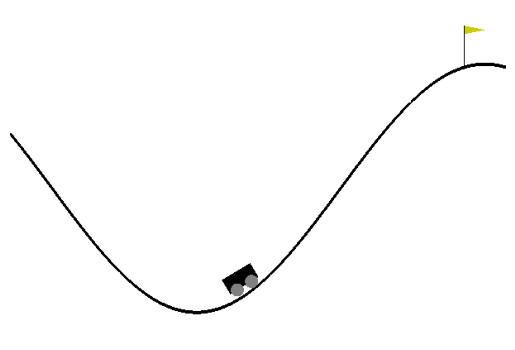

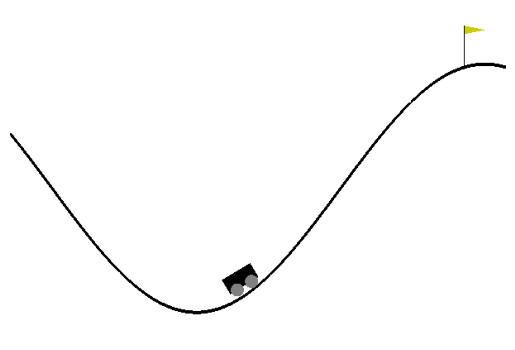

In [16]:
# test_env = gym.make(env_id, render_mode="human")
# test_env = gnwrapper.Animation(test_env)
# test_env = DummyVecEnv([lambda: test_env])

test_env = make_vec_env(env_id,
                        # env_kwargs=dict(
                        #     render_mode="rgb_array"
                        # ),
                        wrapper_class=gnwrapper.Animation,
                        n_envs=1)

expert = PPO.load("./logs/ppo_MountainCar.zip", print_system_info=True)

obs = test_env.reset()

for _ in range(1000):
    action, _states = expert.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render(mode="rgb_array")

    # if dones:
    #     break

test_env.close()

In [17]:
from stable_baselines3.common.evaluation import evaluate_policy

reward, _ = evaluate_policy(expert, test_env, 10)
print(reward)

89.3480352


In [28]:
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
import numpy as np

NUM_EPISODES = 10
full_env = gym.make(env_id)
rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    DummyVecEnv([lambda: RolloutInfoWrapper(full_env)]),
    rollout.make_sample_until(min_timesteps=None, NUM_EPISODES=10),
    rng=rng,
)
# transitions = rollout.flatten_trajectories(rollouts)

In [43]:
from copy import deepcopy
new_rollouts = deepcopy(rollouts)
for i, rollout in enumerate(rollouts):
    new_rollouts[i].obs = np.delete(rollout.obs, 2, 1)

FrozenInstanceError: cannot assign to field 'obs'

In [42]:
new_rollouts[0].obs

array([[-4.57576841e-01,  0.00000000e+00,  1.96773350e-01],
       [-4.56568778e-01,  1.00806670e-03,  1.99737513e-01],
       [-4.54560041e-01,  2.00872310e-03,  2.05638555e-01],
       [-4.51565415e-01,  2.99462653e-03,  2.14422053e-01],
       [-4.47606832e-01,  3.95857124e-03,  2.26006159e-01],
       [-4.42713290e-01,  4.89355577e-03,  2.40282143e-01],
       [-4.36920434e-01,  5.79285063e-03,  2.57114382e-01],
       [-4.30270374e-01,  6.65006461e-03,  2.76341442e-01],
       [-4.22811151e-01,  7.45921116e-03,  2.97776685e-01],
       [-4.14596379e-01,  8.21476895e-03,  3.21210250e-01],
       [-4.05684650e-01,  8.91174376e-03,  3.46410926e-01],
       [-3.96138936e-01,  9.54571646e-03,  3.73129199e-01],
       [-3.86026055e-01,  1.01128938e-02,  4.01100769e-01],
       [-3.75415921e-01,  1.06101418e-02,  4.30050388e-01],
       [-3.64380896e-01,  1.10350158e-02,  4.59696671e-01],
       [-3.52995127e-01,  1.13857742e-02,  4.89756952e-01],
       [-3.41333747e-01,  1.16613815e-02

In [23]:
transitions[1]

{'obs': array([-0.48439482,  0.0012157 ,  0.11734087]),
 'acts': array([1.], dtype=float32),
 'infos': {},
 'next_obs': array([-0.48197246,  0.00242235,  0.12455461]),
 'dones': False}

In [21]:
print(
    f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
"""
)

The `rollout` function generated a list of 100 <class 'imitation.data.types.TrajectoryWithRew'>.
After flattening, this list is turned into a <class 'imitation.data.types.Transitions'> object containing 12945 transitions.
The transitions object contains arrays for: obs, acts, infos, next_obs, dones."



In [14]:
env.observation_space

Box([-1.2  -0.07 -3.  ], [0.6  0.07 3.  ], (3,), float32)

In [19]:
from imitation.algorithms import bc

env = gym.make(env_id, full_obs=False)
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
)

In [21]:
bc_trainer.train(n_epochs=2)
reward, _ = evaluate_policy(bc_trainer.policy, full_env, 10)
print(f"Reward after training: {reward}")

0batch [00:00, ?batch/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x3 and 2x32)